## Hourly Predicitons

Description : 

This notebook regroups the best model from each different approach : single model, sequential multi-tasks and parallel multi-tasks. 

The test set corresponds to the whole month of march. 

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Seed for reproductibility
SEED = 123

import numpy.random
np.random.seed(SEED)

import random
random.seed(SEED)

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [58]:
def TrainTest(house_number,output_1,output_2):
    """
    output is either Demand, Binary_Consumption, Percentage_Consumption or Quantile_Consumption
    """
    X = pd.read_csv(f'Data/house_{house_number}_Features.csv',index_col=0)
    y = pd.read_csv(f'Data/house_{house_number}_Target.csv',index_col=0)
    X.index=pd.to_datetime(X.index)
    y.index=pd.to_datetime(y.index)
    
    X_train = X.loc[:'2018-02']
    X_test = X.loc['2018-03':]
    
    y_train_1 = y.loc[:'2018-02',[output_1]]
    y_test_1 = y.loc['2018-03':,[output_1]]
    
    y_train_2 = y.loc[:'2018-02',[output_2]]
    y_test_2 = y.loc['2018-03':,[output_2]]
        
    return X_train, y_train_1, y_train_2, X_test, y_test_1, y_test_2

In [59]:
houses = [6,40,59,72,87,60] # ID of house selected in the EWHDataset.csv file, respectively called 1-6 in the paper

In [60]:
AXES = 16
LEGEND = 22
TICK = 16
plt.rc('axes', titlesize=AXES)     # fontsize of the axes title
plt.rc('axes', labelsize=AXES)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND)    # legend fontsize

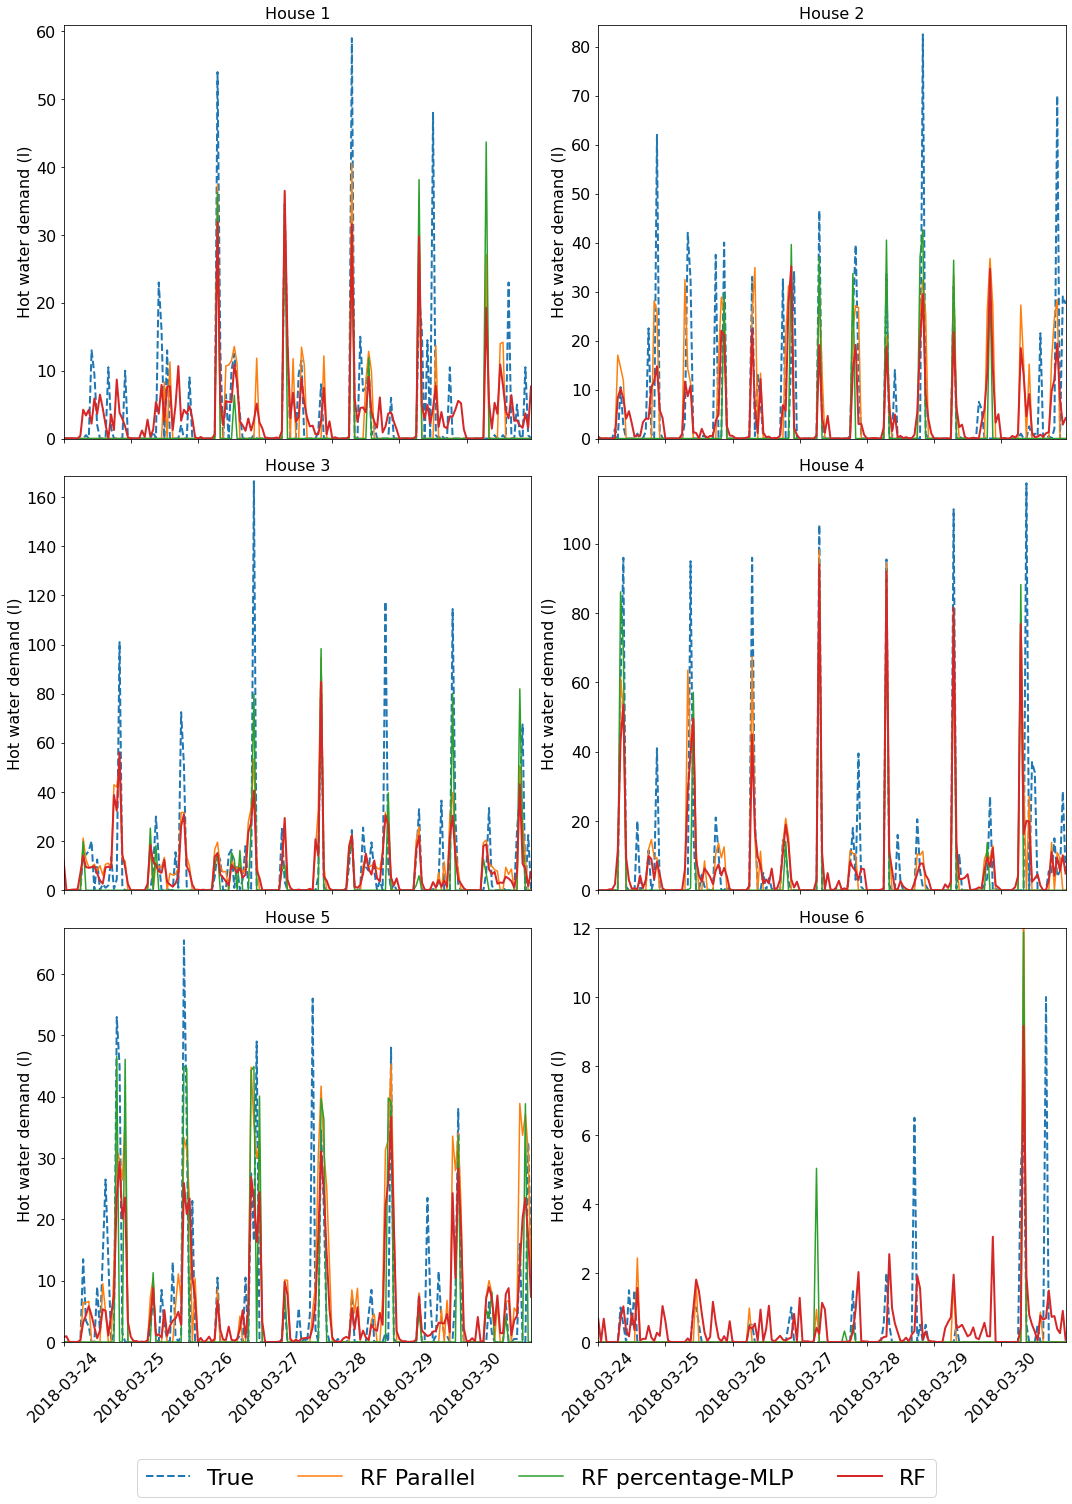

In [72]:
fig, axs = plt.subplots(3,2,figsize=(15,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.7)
axs = axs.ravel()

for idx, house in enumerate(houses):

    X_train, y_train, _, X_test, y_test, _ = TrainTest(house,'Demand','Demand')
    
    # # # True value
    axs[idx].plot(y_test[-168:],'--',linewidth=2.0,label='True')
    
    # # # RF parallel
    
    X_train, y_train_1, y_train_2, X_test, y_test_1, y_test_2 = TrainTest(house,
                                                                      'Binary_Consumption',
                                                                      'Demand')
    # Train the model
    clf_consumption = RandomForestClassifier(n_estimators=500, max_depth=9)
    clf_consumption.fit(X_train,y_train_1)
    
    reg_demand = RandomForestRegressor(n_estimators=500, max_depth=9)
    reg_demand.fit(pd.concat([X_train,y_train_1],axis=1),y_train_2)
    
    # Test
    y_preds_consumption = clf_consumption.predict(X_test)
    
    y_preds = reg_demand.predict(pd.concat([X_test,pd.Series(y_preds_consumption,index=y_test_2.index)],axis=1))
    
    y_preds = pd.Series(y_preds,index=y_test.index)
    axs[idx].plot(y_preds[-168:],label='RF Parallel')
    
    # # # RF Percentage MLP
    X_train, y_train_1, y_train_2, X_test, y_test_1, y_test_2 = TrainTest(house,
                                                                      'Percentage_Consumption',
                                                                      'Demand')
    
    clf_consumption = RandomForestClassifier(n_estimators=500, max_depth=9)
    
    clf_consumption.fit(X_train,y_train_1)
    
    # Train regression - Model predicts the amount of hot water :
    X_train_tot = pd.concat([X_train,y_train_1],axis=1) # Concatenate 
    
    # Create the architecture of the model 
    inputs = Input(shape=(20,), name='inputs')
    x = Dense(16, activation='relu')(inputs)
    demand = Dense(1, activation='relu',name='demand')(x)
    
    # Create the model
    model = Model(inputs=[inputs], outputs=[demand])
    
    # Compile
    model.compile(optimizer='adam',
                  loss={'demand':'mse'},
                  metrics={'demand':'mse'})
    # Fit 
    log_seq = model.fit({'inputs': X_train_tot},{'demand': y_train_2},
              epochs=64, batch_size=16,verbose=0)
    
    # Test
    # First predict the category of consumption 
    category_consumption_preds = clf_consumption.predict(X_test)

    y_preds = model.predict(pd.concat([X_test,pd.Series(category_consumption_preds,index=y_test_2.index)],axis=1))
    y_preds = pd.Series(y_preds.reshape(-1),index=y_test.index)
    axs[idx].plot(y_preds[-168:],label='RF percentage-MLP')
    
    # # # Random forest
    reg = RandomForestRegressor(n_estimators = 100, 
                            min_samples_split = 17,
                            random_state=SEED)

    reg.fit(X_train,y_train)

    y_preds = reg.predict(X_test)
    y_preds[y_preds<0] = 0
    y_preds = pd.Series(y_preds,index=y_test.index)
    axs[idx].plot(y_preds[-168:],linewidth=2.0,label='RF')
    
    # Figure details
    axs[idx].title.set_text(f'House {idx+1}')
    axs[idx].set_ylabel('Hot water demand (l)')
    axs[idx].set_xlim(y_test.index[-168],y_test.index[-1])
    axs[idx].set_ylim(0, y_test[-168:].max().values[0]+2)
    
    if idx <= 3:
        axs[idx].set_xticklabels([])
    else:
        axs[idx].tick_params(axis='x',rotation=45)
    
handles, labels = axs[5].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_transform=fig.transFigure,bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.tight_layout()